In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings

warnings.filterwarnings('ignore')

# Загрузка данных

In [ ]:
df = pd.read_csv('drive/MyDrive/Heart_Disease_Prediction.csv')

In [ ]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

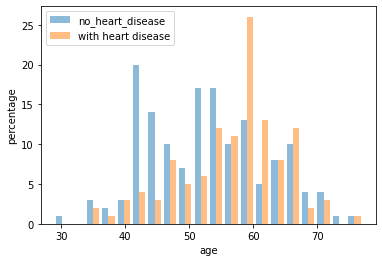

In [ ]:
plt.hist([df[df["Heart Disease"]=="Absence"].Age, df[df["Heart Disease"]=="Presence"].Age], bins = 20, alpha = 0.5, label = ["no_heart_disease","with heart disease"])
plt.xlabel("age")
plt.ylabel("percentage")
plt.legend()
plt.show()

In [ ]:
y = df["Heart Disease"]
df.drop("Heart Disease", axis=1, inplace=True)
print(y.value_counts())

Absence     150
Presence    120
Name: Heart Disease, dtype: int64


Заменим название категории и разделим их на разные столбцы

In [ ]:
categorical_features = ["Sex", "Chest pain type", "FBS over 120", "EKG results", "Exercise angina", "ST depression", "Number of vessels fluro", "Thallium"]
df[categorical_features] = df[categorical_features].astype("category")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
continuous_features = set(df.columns) - set(categorical_features)
scaler = MinMaxScaler()
X = df.copy()
X[list(continuous_features)] = scaler.fit_transform(df[list(continuous_features)])

In [ ]:
X

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,0.854167,1,4,0.339623,0.447489,0,2,0.290076,0,2.4,0.5,3,3
1,0.791667,0,3,0.198113,1.000000,0,2,0.679389,0,1.6,0.5,0,7
2,0.583333,1,2,0.283019,0.308219,0,0,0.534351,0,0.3,0.0,0,7
3,0.729167,1,4,0.320755,0.312785,0,0,0.259542,1,0.2,0.5,1,7
4,0.937500,0,2,0.245283,0.326484,0,2,0.381679,1,0.2,0.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.479167,1,3,0.735849,0.166667,1,0,0.694656,0,0.5,0.0,0,7
266,0.312500,1,2,0.245283,0.312785,0,0,0.778626,0,0.0,0.0,0,7
267,0.562500,0,2,0.433962,0.383562,0,2,0.625954,0,1.3,0.5,0,3
268,0.583333,1,4,0.433962,0.150685,0,0,0.587786,0,0.4,0.5,0,6


# Одномерный отбор признаков

In [ ]:
X.columns.size

13

In [ ]:
X.columns

Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
       'Slope of ST', 'Number of vessels fluro', 'Thallium'],
      dtype='object')

In [ ]:
skb = SelectKBest(k=2, score_func=chi2)
X_new1 = skb.fit_transform(X, y)

In [ ]:
pd.DataFrame(data={'score':skb.scores_}, 
             index=X.columns).sort_values(by='score')

,score
FBS over 120,0.061250
Cholesterol,0.184806
BP,0.523440
Age,0.824226
Max HR,2.453241
Sex,7.711475
EKG results,8.688587
Slope of ST,9.889241
Chest pain type,13.330455
Exercise angina,31.822472


In [ ]:
X_new1.shape

(270, 6)

# Рекурсивное исключение признаков

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
X_new2 = rfe.fit_transform(X, y)
X_new2

array([[4.        , 0.44748858, 0.29007634, 2.4       , 3.        ],
       [3.        , 1.        , 0.67938931, 1.6       , 7.        ],
       [2.        , 0.30821918, 0.53435115, 0.3       , 7.        ],
       ...,
       [2.        , 0.38356164, 0.6259542 , 1.3       , 3.        ],
       [4.        , 0.15068493, 0.58778626, 0.4       , 6.        ],
       [4.        , 0.3652968 , 0.28244275, 1.5       , 3.        ]])

In [ ]:
pd.DataFrame(data={'score':rfe.ranking_,
                   'support':rfe.get_support()}, 
             index=X.columns).sort_values(by='score')

,score,support
Chest pain type,1,True
Cholesterol,1,True
Max HR,1,True
ST depression,1,True
Thallium,1,True
Number of vessels fluro,2,False
BP,3,False
Age,4,False
Slope of ST,5,False
Exercise angina,6,False


Выбираем первые 6 признаков: sex_Male, cp_atypical angina, cp_non-anginal pain, cp_typical angina, eslope_upsloping, thal_reversable defect

# Метод главных компонент

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# feature extraction
pca = PCA(n_components=6)
X_new3 = pca.fit_transform(X, y)

# summarize components
print("Explained Variance: ",pca.explained_variance_ratio_)
print(X_new3[0:5,:])

Explained Variance:  [0.48895719 0.15234791 0.10744672 0.09865556 0.08055799 0.02258517]
[[-0.62844628  2.93760075 -0.29766082 -1.06189992  1.17955083 -0.16931654]
 [ 2.08240403 -0.13133725 -0.37911578  1.28632622 -0.58032968  1.10202791]
 [ 1.57502857 -2.3126685   0.50344007  0.84614964  0.35055748  0.07415707]
 [ 2.17451635 -1.44892111 -0.24282888 -1.09671865 -0.0423531  -0.38077143]
 [-1.91262767  0.37215569 -0.82669794  0.67909252  0.86015243 -0.06053209]]


In [ ]:
evr = pca.explained_variance_ratio_
pca_df = pd.DataFrame()
pca_df['Explained Variance Ratio'] = evr
pca_df.head(10)

,Explained Variance Ratio
0,0.488957
1,0.152348
2,0.107447
3,0.098656
4,0.080558
5,0.022585


# Отбор на основе важности признаков

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier 

In [ ]:
tree = ExtraTreesClassifier()
tree.fit(X, y)
print(tree.feature_importances_)

[0.07414554 0.04662345 0.1095705  0.06373451 0.06479833 0.02156024
 0.03602395 0.07287552 0.0859242  0.07618508 0.053847   0.13174955
 0.16296212]


In [ ]:
pd.DataFrame(data={'score':tree.feature_importances_}, 
             index=X.columns)

,score
Age,0.074146
Sex,0.046623
Chest pain type,0.109571
BP,0.063735
Cholesterol,0.064798
FBS over 120,0.021560
EKG results,0.036024
Max HR,0.072876
Exercise angina,0.085924
ST depression,0.076185


In [ ]:
X_new4 = X[["Age","Sex","Chest pain type","BP","Cholesterol","FBS over 120"]]
X_new4.values

array([[0.85416667, 1.        , 4.        , 0.33962264, 0.44748858,
        0.        ],
       [0.79166667, 0.        , 3.        , 0.19811321, 1.        ,
        0.        ],
       [0.58333333, 1.        , 2.        , 0.28301887, 0.30821918,
        0.        ],
       ...,
       [0.5625    , 0.        , 2.        , 0.43396226, 0.38356164,
        0.        ],
       [0.58333333, 1.        , 4.        , 0.43396226, 0.15068493,
        0.        ],
       [0.79166667, 1.        , 4.        , 0.62264151, 0.3652968 ,
        0.        ]])

# Проверка на моделях

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split

In [ ]:
print(X_new1)
print(X_new2)
print(X_new3)
print(X_new4)

[[4.  0.  2.4 0.5 3.  3. ]
 [3.  0.  1.6 0.5 0.  7. ]
 [2.  0.  0.3 0.  0.  7. ]
 ...
 [2.  0.  1.3 0.5 0.  3. ]
 [4.  0.  0.4 0.5 0.  6. ]
 [4.  1.  1.5 0.5 3.  3. ]]
[[4.         0.44748858 0.29007634 2.4        3.        ]
 [3.         1.         0.67938931 1.6        7.        ]
 [2.         0.30821918 0.53435115 0.3        7.        ]
 ...
 [2.         0.38356164 0.6259542  1.3        3.        ]
 [4.         0.15068493 0.58778626 0.4        6.        ]
 [4.         0.3652968  0.28244275 1.5        3.        ]]
[[-0.62844628  2.93760075 -0.29766082 -1.06189992  1.17955083 -0.16931654]
 [ 2.08240403 -0.13133725 -0.37911578  1.28632622 -0.58032968  1.10202791]
 [ 1.57502857 -2.3126685   0.50344007  0.84614964  0.35055748  0.07415707]
 ...
 [-1.8566845   0.7434512   0.04748313  1.4036111  -0.0377495   0.54168413]
 [ 1.03819711 -1.42686864  0.12519662 -0.69186482 -0.77473087  0.08070713]
 [-0.77725087  2.40139679 -0.86313251 -1.28396519  1.19716713 -0.74318723]]
          Age Sex Ches

## До отбора признаков

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = nb.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[39  7]
 [ 7 28]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.85      0.85      0.85        46
    Presence       0.80      0.80      0.80        35

    accuracy                           0.83        81
   macro avg       0.82      0.82      0.82        81
weighted avg       0.83      0.83      0.83        81

Accuracy: 0.8271604938271605


In [ ]:
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)

In [ ]:
y_pred = dtc.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[38  8]
 [ 8 27]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.83      0.83      0.83        46
    Presence       0.77      0.77      0.77        35

    accuracy                           0.80        81
   macro avg       0.80      0.80      0.80        81
weighted avg       0.80      0.80      0.80        81

Accuracy: 0.8024691358024691


## После отбора

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new1, y, test_size=0.3, shuffle = False)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[42  4]
 [ 5 30]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.89      0.91      0.90        46
    Presence       0.88      0.86      0.87        35

    accuracy                           0.89        81
   macro avg       0.89      0.89      0.89        81
weighted avg       0.89      0.89      0.89        81

Accuracy: 0.8888888888888888


In [ ]:
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[38  8]
 [ 9 26]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.81      0.83      0.82        46
    Presence       0.76      0.74      0.75        35

    accuracy                           0.79        81
   macro avg       0.79      0.78      0.79        81
weighted avg       0.79      0.79      0.79        81

Accuracy: 0.7901234567901234


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new2, y, test_size=0.3, shuffle = False)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[37  9]
 [ 6 29]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.86      0.80      0.83        46
    Presence       0.76      0.83      0.79        35

    accuracy                           0.81        81
   macro avg       0.81      0.82      0.81        81
weighted avg       0.82      0.81      0.82        81

Accuracy: 0.8148148148148148


In [ ]:
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[39  7]
 [ 9 26]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.81      0.85      0.83        46
    Presence       0.79      0.74      0.76        35

    accuracy                           0.80        81
   macro avg       0.80      0.80      0.80        81
weighted avg       0.80      0.80      0.80        81

Accuracy: 0.8024691358024691


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new3, y, test_size=0.3, shuffle = False)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[36 10]
 [ 4 31]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.90      0.78      0.84        46
    Presence       0.76      0.89      0.82        35

    accuracy                           0.83        81
   macro avg       0.83      0.83      0.83        81
weighted avg       0.84      0.83      0.83        81

Accuracy: 0.8271604938271605


In [ ]:
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[35 11]
 [10 25]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.78      0.76      0.77        46
    Presence       0.69      0.71      0.70        35

    accuracy                           0.74        81
   macro avg       0.74      0.74      0.74        81
weighted avg       0.74      0.74      0.74        81

Accuracy: 0.7407407407407407


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new4, y, test_size=0.3, shuffle = False)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[30 16]
 [11 24]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.73      0.65      0.69        46
    Presence       0.60      0.69      0.64        35

    accuracy                           0.67        81
   macro avg       0.67      0.67      0.66        81
weighted avg       0.67      0.67      0.67        81

Accuracy: 0.6666666666666666


In [ ]:
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))

Confusion Matrix:
[[31 15]
 [ 7 28]]
Classification Report:
              precision    recall  f1-score   support

     Absence       0.82      0.67      0.74        46
    Presence       0.65      0.80      0.72        35

    accuracy                           0.73        81
   macro avg       0.73      0.74      0.73        81
weighted avg       0.74      0.73      0.73        81

Accuracy: 0.7283950617283951
